# DSM150 - Neural Networks Coursework 2

## Introduction

Introduced to the major public ChatGPT quickly demonstrated the enormous potential of Large Language Models(LLMs). This marked the beginning of a new era where the concepts of neural networks left academic circles, becoming a topic of conversations of everyday life. Subsequently, these LLMs introduced the capability of image recognition. Users are able to upload images and let them be analyzed and described by LLMs, which further underlined the versatility and potential of neural networks. Today, Convolutional Neural Networks have found extensive application across various fields. From medical imaging, such as fraction detection in x-ray images, to the 'simple' object detection on smartphones. The impact of CNNs is both profound and pervasive. This coursework report seeks to explore the practical realization of CNNs, as presented in "Deep Learning with Python", highlighting the indispensable role in the digital age. 


### Classification Task Overview

Following to the introduction, this section aims to define the specific classification task that forms the core focus of the coursework. The objective is to develop an CNN model capable to accurately classify images of animals into five distinct category, each representing a different type of animal. The animals for the classification tasks are as follows:
- Category 1: Cat
- Category 2: Dog
- Category 3: Elephant
- Category 4: Horse
- Category 5: Lion

The task is designed ti challenge the models ability to discem and learn from the unique feature characteristics of each animal type, ranging from texture and shape to size and environmental context. 





## Dataset Description

The dataset that is used for the classification task holds images representing five distinct animal categories ( also see 'Classification Task Overview'). These datset was sourced from Kaggle and can be found under the name 'Animals - Animals Classification Dataset [1]'. It contains 15'000 pictures of animals, which has been collected from Google Images. The Dataset is splitted in training images and validation images. The validation sets holds 300 images for each animal type. This roughly represents the relative size of 11% of the training images.

## Course Work Approach

This course work adopts a structured, iterative approach to explore, implement and refine Convolutional Neural Networks (CNNs) for an image recognitions task. The approach can be subdivided into distinct phases, each designed to build-up on the previous steps.  The process is as follows:

1. Exploring the Images:
- Show Images: A subset of the dataset will be visually examined to understand the variety and characteristics of the data. This step is designed to create an understanding of potential challenges in image recognition tasks, such as image orientation and lighting.
- Count of Images -> Class Distribution: This step is designed to picture the class distribution of target classes. This step is supposed to detect any class imbalances. A balanced dataset is essential to create a robust and unbiased model.

2. Loading and Preparation:
- This phase covers the image loading and preparation for the model training. This tasks covers preprocessing steps like image normalizing and rescaling the data, implementing an image generator and applying data augmentation techniques.

3. Define a Base Model:
- A baseline CNN is created and trained on the dataset prepared on the previous step. The model is supposed to serve as a reference in terms of performance and accuracy to identify areas of improvement.

4. Evaluate Base Model:
- Print Standard Parameters: Commonly parameters will be plotted such as trainings and validation accuracy in relation to observe the different training stages of the model. 
- Print Confusion Matrix: The performance of the baseline model will be evaluated by creating a confusion matrix, which gives insights to the models accuracy, recall and precision.

5. Structured Approach to improve Base Model:
- A systematic approach will be employed to  iteratively improve the base model. This involves changes in the architectures.

6. Using a Pretraine Convolutional Network:
- To further discover different techniques, a pretrained CNN will be incorporated. This approach will a allow the model to benefit from features learned on  vast amount of pictures and objects, aiming to improve the generalization capabilities. 

7. Visualizing Structures:
- Finally, the internal structures and features learned by the CNN will be visualized. This step is crucial for understanding how the model interprets and processes image data, providing valuable insights into its decision-making process.

## 1. Exploring the Images:

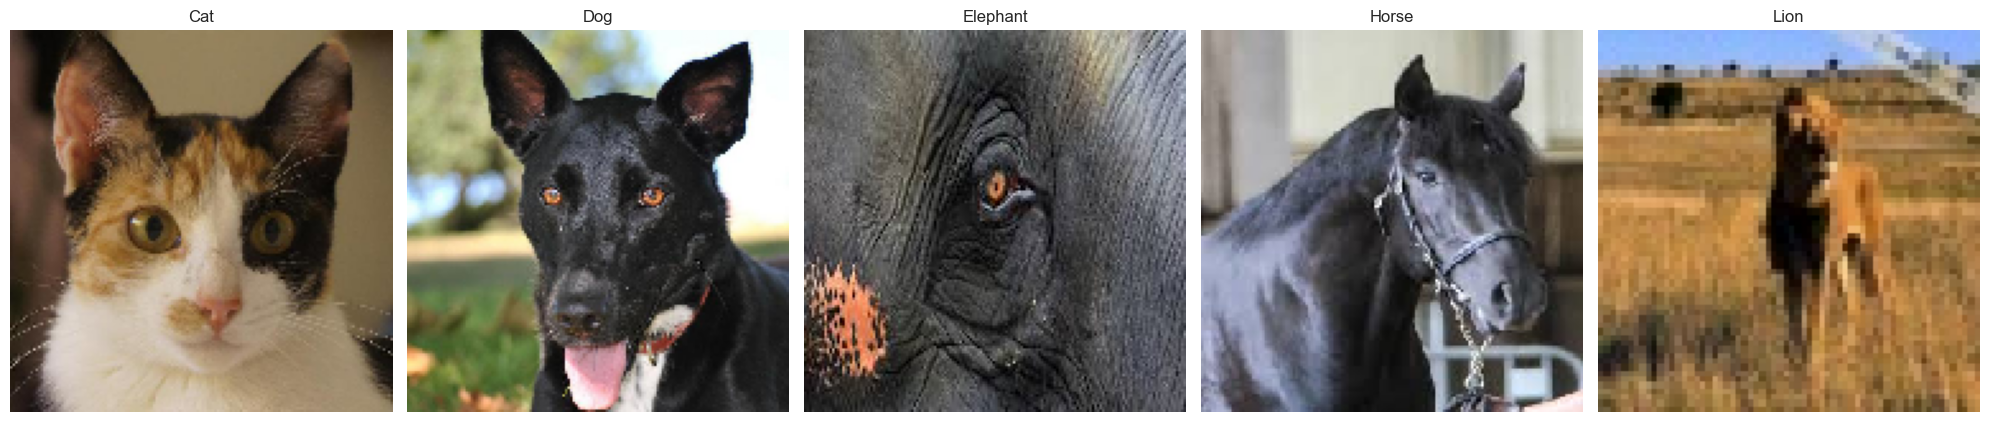

In [1]:
import os, random

import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt

dir_base_train= './data/animals/train/'
dir_train_cat= os.path.join(dir_base_train,'cat')
dir_train_dog= os.path.join(dir_base_train,'dog')
dir_train_elephant= os.path.join(dir_base_train,'elephant')
dir_train_horse= os.path.join(dir_base_train,'horse')
dir_train_lion= os.path.join(dir_base_train,'lion')

cat_path_img= os.path.join(dir_train_cat, random.choice(os.listdir(dir_train_cat)))
dog_path_img= os.path.join(dir_train_dog,random.choice(os.listdir(dir_train_dog)))
elephant_path_img= os.path.join(dir_train_elephant,random.choice(os.listdir(dir_train_elephant)))
horse_path_img= os.path.join(dir_train_horse, random.choice(os.listdir(dir_train_horse)))
lion_path_img= os.path.join(dir_train_lion, random.choice(os.listdir(dir_train_lion)))

cat_img = image.img_to_array(image.load_img(cat_path_img, target_size=(150,150)))
dog_img = image.img_to_array(image.load_img(dog_path_img, target_size=(150,150)))
elephant_img = image.img_to_array(image.load_img(elephant_path_img, target_size=(150,150)))
horse_img = image.img_to_array(image.load_img(horse_path_img, target_size=(150,150)))
lion_img = image.img_to_array(image.load_img(lion_path_img, target_size=(150,150)))

# Set up the matplotlib figure and axes, specifying the figure size and the grid layout
fig, axes = plt.subplots(1, 5, figsize=(20, 10))

# List of the images
images = [cat_img, dog_img, elephant_img, horse_img, lion_img]

# Titles for each subplot
titles = ['Cat', 'Dog', 'Elephant', 'Horse', 'Lion']

# Plot each image
for i, ax in enumerate(axes.flat):
    # Display image
    ax.imshow(images[i] / 255.)  # Normalize the image to [0,1] since matplotlib expects floats in [0,1] or integers in [0, 255]
    ax.set_title(titles[i])  # Set a title for each subplot
    ax.axis('off')  # Turn off axis

plt.tight_layout()  # Adjust subplots to fit into figure area.
plt.show()  # Display the figure with the images


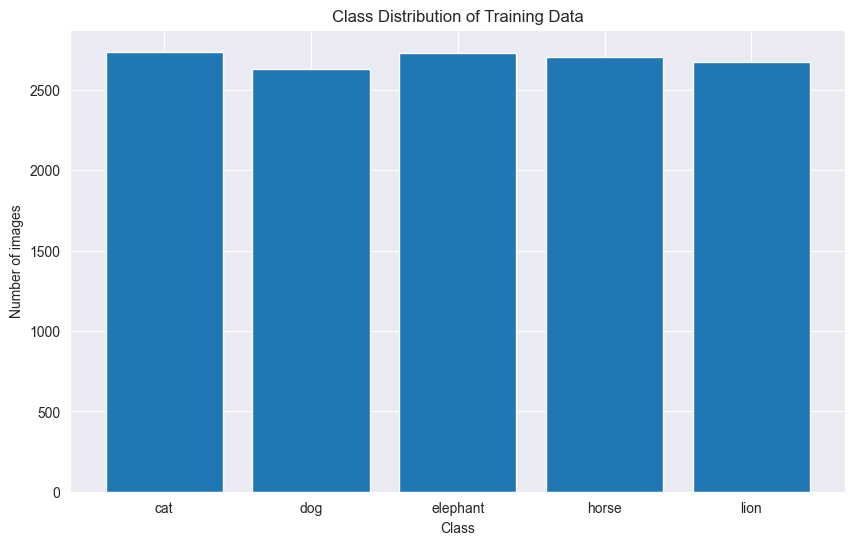

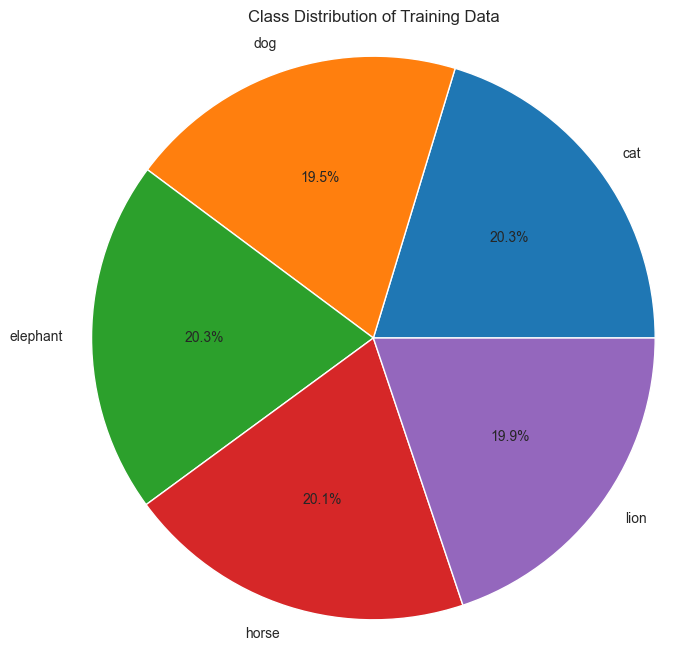

In [2]:
# Class distributions Images
classes = ['cat', 'dog', 'elephant', 'horse', 'lion']
class_counts = {}

for class_name in classes:
    dir_path = os.path.join(dir_base_train, class_name)
    class_counts[class_name] = len([entry for entry in os.listdir(dir_path) if os.path.isfile(os.path.join(dir_path, entry))])

# Data
classes = list(class_counts.keys())
counts = list(class_counts.values())

# Create bar chart
plt.figure(figsize=(10, 6))
plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Class Distribution of Training Data')
plt.show()

# Create pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=classes, autopct='%1.1f%%')
plt.title('Class Distribution of Training Data')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.show()

On the above charts can be seen, that the data is almost equally distributed. Only minor differences can be stopped between each class. As a result there is not need to take care of under- or overrepresented classes in the process of data preparation. There is no risk of a bias caused by an imbalanced dataset.

# 2. Loading and Preparation

The used dateset was downloaded from Kaggel. The dataset originally consists of a 'train' and 'val' folder. Both folders will be used training the model. To generate an unbiased measure of the models performance a test set will be created an hold back to evaluated the model with unseen data.

In [45]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

In [46]:
# define base directory where pictures stored
dir_base_train= './data/animals/train/'
dir_base_val= './data/animals/val/'
dir_base_test= './data/animals/test/'

In [48]:
import os, shutil
from sklearn.model_selection import train_test_split

animal_classes= ['cat', 'dog', 'elephant','horse', 'lion'] 


# define relative size testset
test_size= 0.1

# define a directory for each class

for class_dir in animal_classes:
    
    dest_dir= os.path.join(dir_base_test, class_dir)
    
    # define the source directory
    src_dir= os.path.join(dir_base_train, class_dir)
    
    # get all the files names from the dir
    fnames= os.listdir(src_dir)
    
    train_files, test_files = train_test_split(fnames, test_size=test_size, random_state= 42)
    
    # define destination dir
    os.makedirs(dest_dir, exist_ok=True)
    
    # move files to test dir
    for fname in test_files:
        shutil.move(os.path.join(dir_base_train, class_dir, fname), os.path.join(dest_dir, fname))

In [49]:
# import lib for Image Generator
#from keras.preprocessing.image import ImageDataGenerator

# rescale images by 1/255
train_datagen= ImageDataGenerator(rescale=1./255)
val_datagen= ImageDataGenerator(rescale=1./255)
test_datagen= ImageDataGenerator(rescale=1./255)

In [50]:

# read img from target dirs, resize image to 150x150, 
train_generator= train_datagen.flow_from_directory(
    dir_base_train,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= True
    
)


Found 12125 images belonging to 5 classes.


In [51]:
val_generator= val_datagen.flow_from_directory(
    dir_base_val,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle=True
)

Found 1497 images belonging to 5 classes.


In [52]:
# define generator fo test data
test_generator= test_datagen.flow_from_directory(
    dir_base_test,
    target_size= (150,150),
    batch_size= 64,
    class_mode= 'categorical',
    shuffle= False
)

Found 1349 images belonging to 5 classes.


In [53]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (64, 150, 150, 3)
Labels batch shape: (64, 5)


In [54]:
input_shape= (150, 150, 3)

## 3. Define a Base Model

In the following section a base model is defined. The base model should serve as a reference point building a more precise model. The aim is to keep the base model as simple as possible and achieving a statistical signiificanc 


In [55]:
# intializing model
model= models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape= input_shape))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(32, (3,3), activation= 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation= 'relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(5, activation='softmax'))

In [56]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 17, 17, 64)       

In [57]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [58]:
steps_per_epoch= train_generator.samples // train_generator.batch_size
validation_steps= val_generator.samples // val_generator.batch_size

In [59]:
train_generator.samples // train_generator.batch_size

189

In [60]:
history= model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 20,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/20
189/189 [==============================] - 27s 139ms/step - loss: 1.0655 - accuracy: 0.5599 - val_loss: 0.7326 - val_accuracy: 0.7201
Epoch 2/20
189/189 [==============================] - 27s 141ms/step - loss: 0.6644 - accuracy: 0.7411 - val_loss: 0.6405 - val_accuracy: 0.7269
Epoch 3/20
189/189 [==============================] - 27s 140ms/step - loss: 0.5151 - accuracy: 0.8008 - val_loss: 0.4667 - val_accuracy: 0.8268
Epoch 4/20
189/189 [==============================] - 27s 143ms/step - loss: 0.4366 - accuracy: 0.8303 - val_loss: 0.4339 - val_accuracy: 0.8261
Epoch 5/20
189/189 [==============================] - 27s 143ms/step - loss: 0.3740 - accuracy: 0.8547 - val_loss: 0.4395 - val_accuracy: 0.8329
Epoch 6/20
189/189 [==============================] - 27s 145ms/step - loss: 0.3283 - accuracy: 0.8722 - val_loss: 0.4057 - val_accuracy: 0.8404
Epoch 7/20
189/189 [==============================] - 27s 145ms/step - loss: 0.2704 - accuracy: 0.8946 - val_loss: 0.3922 - val_ac

## 4. Evaluate Base Model

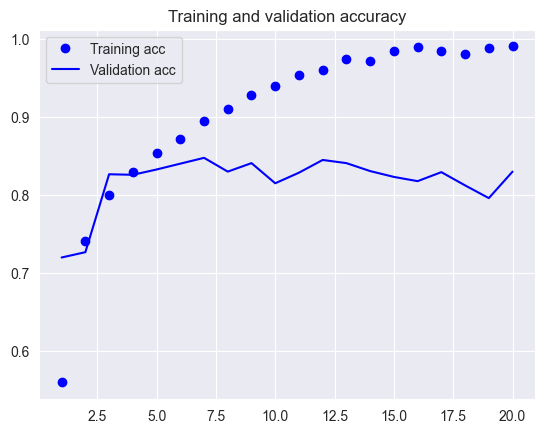

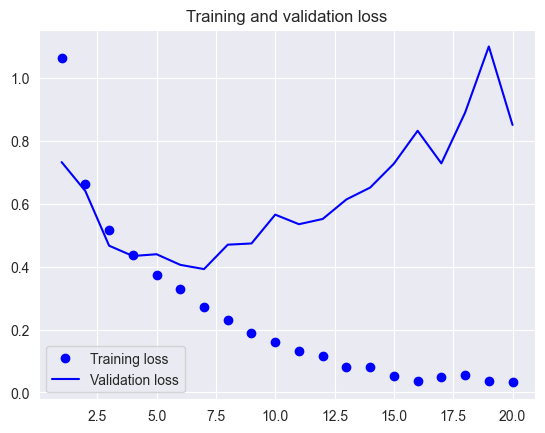

In [61]:
import matplotlib.pyplot as plt

acc= history.history['accuracy']
val_acc= history.history['val_accuracy']
loss= history.history['loss']
val_loss= history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The fist model shows typicall signs of overfitting as the training accuracy is increasing and the validation accuracy stagnates a around 80% accuracy. A fimilar pattern can be observed for the training and validation loss. The training is decreasing in each new epoch. Whereas the validation loss increases from the 7th epoch onwards.

In the next step I will evaluate the model using the test data.

22/22 [==============================] - 2s 90ms/step


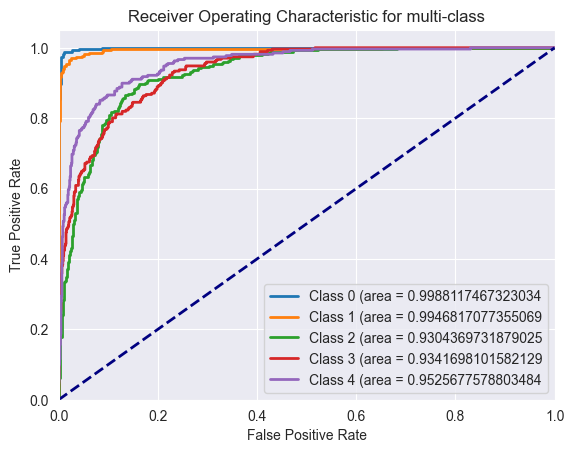

Overall ROC AUC: 0.9621335991388549


In [64]:
from sklearn.metrics import roc_curve, auc, roc_auc_score
import numpy as np

test_steps= np.ceil(test_generator.samples / test_generator.batch_size).astype(int)

prediction_probabilities= model.predict(test_generator, steps= test_steps)

# get true labels
true_labels= test_generator.classes

from tensorflow.keras.utils import to_categorical

true_labels= to_categorical(true_labels, num_classes=5)

roc_auc_dict= {}

for i in range(5):
    fpr, tpr, thresholds = roc_curve(true_labels[:, i], prediction_probabilities[:,i])
    roc_auc= auc(fpr, tpr)
    roc_auc_dict[f'(i)']= roc_auc
    plt.plot(fpr, tpr, lw= 2, label= f'Class {i} (area = {roc_auc}')
    
# Plot the ROC curves
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for multi-class')
plt.legend(loc="lower right")
plt.show()

# Calculate the overall ROC AUC score
roc_auc_score = roc_auc_score(true_labels, prediction_probabilities, multi_class='ovo')  # 'ovo' for One-vs-One comparison
print('Overall ROC AUC:', roc_auc_score)



Inspecting the ROC-Curves for the model it perfomrms surprisingly well taking into consideration that the model showed signs of overfitting with the trainings and validation data. Each curve for each clase is close to the top lef corner, that indicates that the model is effectively distinguishing between the classes. Beside earlier concerns the model demonstrates that it could generalize well from the trainings data to unseen data.

In the next steps a more simple model is evaluated.

In [65]:
# intializing model
simple_model= models.Sequential()
simple_model.add(layers.Conv2D(8, (3,3), activation='relu', input_shape= input_shape))
simple_model.add(layers.MaxPooling2D((2,2)))
simple_model.add(layers.Conv2D(16, (3,3), activation= 'relu'))
simple_model.add(layers.MaxPooling2D((2,2)))
simple_model.add(layers.Flatten())
simple_model.add(layers.Dense(20, activation='relu'))
simple_model.add(layers.Dense(5, activation='softmax'))

In [66]:
simple_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
simple_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 148, 148, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 74, 74, 8)         0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 72, 72, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 36, 36, 16)        0         
 g2D)                                                            
                                                                 
 flatten_3 (Flatten)         (None, 20736)             0         
                                                                 
 dense_6 (Dense)             (None, 20)               

In [30]:
simple_history= simple_model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 30,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/30
210/210 [==============================] - 26s 123ms/step - loss: 1.0883 - accuracy: 0.5740 - val_loss: 0.9390 - val_accuracy: 0.6488
Epoch 2/30
210/210 [==============================] - 26s 122ms/step - loss: 0.8901 - accuracy: 0.6368 - val_loss: 0.8568 - val_accuracy: 0.6780
Epoch 3/30
210/210 [==============================] - 25s 120ms/step - loss: 0.7965 - accuracy: 0.6746 - val_loss: 0.7649 - val_accuracy: 0.6848
Epoch 4/30
210/210 [==============================] - 25s 119ms/step - loss: 0.7147 - accuracy: 0.7123 - val_loss: 0.6999 - val_accuracy: 0.7289
Epoch 5/30
210/210 [==============================] - 24s 116ms/step - loss: 0.6435 - accuracy: 0.7450 - val_loss: 0.6965 - val_accuracy: 0.7140
Epoch 6/30
210/210 [==============================] - 25s 117ms/step - loss: 0.6064 - accuracy: 0.7623 - val_loss: 0.6067 - val_accuracy: 0.7636
Epoch 7/30
210/210 [==============================] - 25s 117ms/step - loss: 0.5558 - accuracy: 0.7867 - val_loss: 0.5829 - val_ac

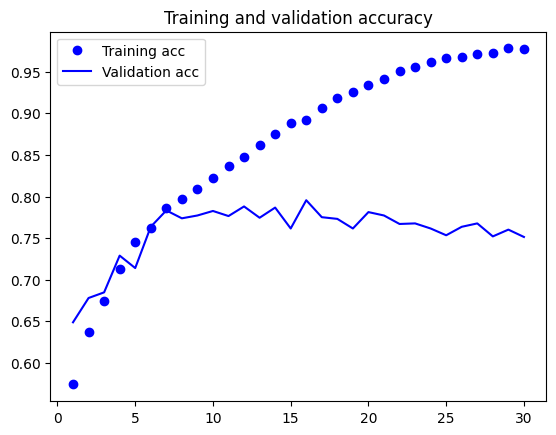

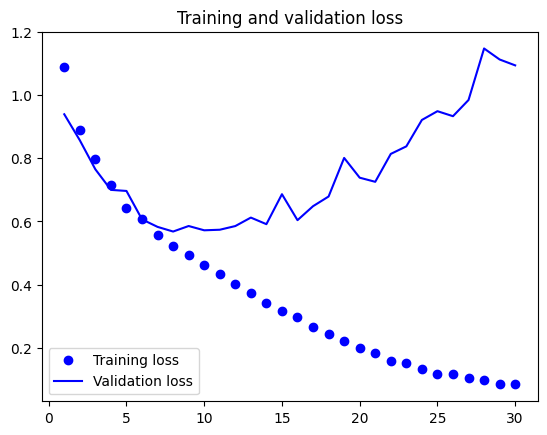

In [31]:
import matplotlib.pyplot as plt

acc= simple_history.history['accuracy']
val_acc= simple_history.history['val_accuracy']
loss= simple_history.history['loss']
val_loss= simple_history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Applying Data Augmentation

In [70]:
train_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range= 0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip= True,
    fill_mode='nearest'
)

In [71]:
val_aug_img_data_gen= ImageDataGenerator(
    rescale= 1./255,
)

In [97]:
train_aug_generator= train_aug_img_data_gen.flow_from_directory(
    dir_base_train,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= True
)

Found 13474 images belonging to 5 classes.


In [98]:
val_aug_generator= val_aug_img_data_gen.flow_from_directory(
    dir_base_val,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= True  
)

Found 1497 images belonging to 5 classes.


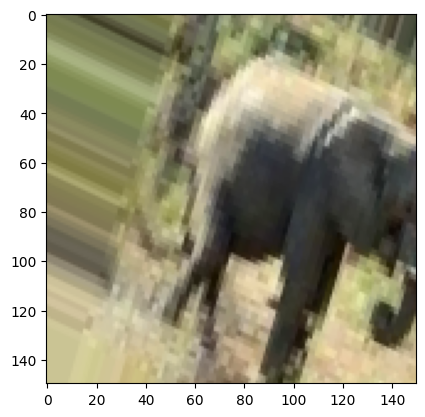

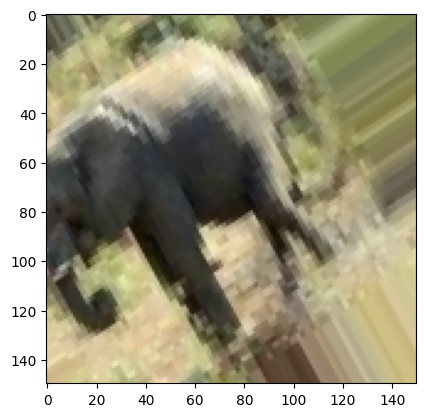

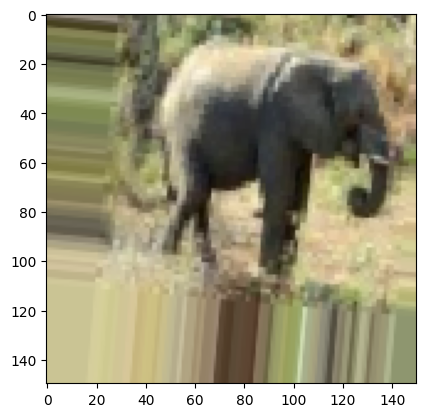

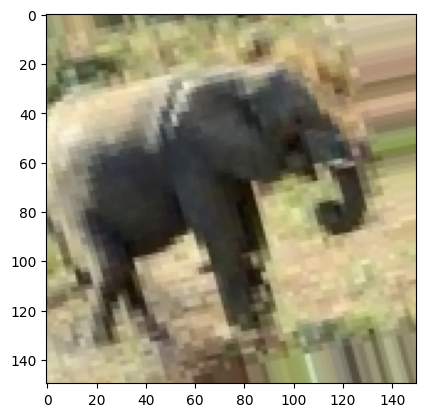

In [74]:
# displaying some random pics
from keras.preprocessing import image

fnames= [os.path.join('./data/animals/train/elephant', fname) for fname in os.listdir('./data/animals/train/elephant') ]

img_path= fnames[3]

img= image.load_img(img_path, target_size=(150,150))

x= image.img_to_array(img)
x= x.reshape((1,) + x.shape)

i=0

for batch in train_aug_img_data_gen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot= plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
    
plt.show()

In [113]:
from tensorflow.keras import regularizers

# intializing model
model_da= models.Sequential()
model_da.add(layers.Conv2D(32, (3,3), activation='relu', input_shape= input_shape, kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Dropout(0.5))
model_da.add(layers.Conv2D(64, (3,3), activation= 'relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Dropout(0.5))
model_da.add(layers.Conv2D(128, (3,3), activation= 'relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.MaxPooling2D((2,2)))
model_da.add(layers.Flatten())
model_da.add(layers.Dropout(0.5))
model_da.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-5)))
model_da.add(layers.Dense(5, activation='softmax'))

In [114]:
model_da.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model_da.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])

In [115]:
steps_per_epoch= train_aug_generator.samples // train_aug_generator.batch_size
validation_steps= val_aug_generator.samples // train_aug_generator.batch_size

In [145]:
history_da= model_da.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs= 50,
    validation_data= val_generator,
    validation_steps= validation_steps
)

Epoch 1/50
210/210 [==============================] - 56s 264ms/step - loss: 0.1098 - accuracy: 0.9802 - val_loss: 0.6078 - val_accuracy: 0.8560
Epoch 2/50
210/210 [==============================] - 54s 257ms/step - loss: 0.1010 - accuracy: 0.9832 - val_loss: 0.6420 - val_accuracy: 0.8546
Epoch 3/50
210/210 [==============================] - 55s 261ms/step - loss: 0.1080 - accuracy: 0.9811 - val_loss: 0.6806 - val_accuracy: 0.8424
Epoch 4/50
210/210 [==============================] - 54s 257ms/step - loss: 0.1066 - accuracy: 0.9810 - val_loss: 0.7860 - val_accuracy: 0.8438
Epoch 5/50
210/210 [==============================] - 55s 259ms/step - loss: 0.1111 - accuracy: 0.9814 - val_loss: 0.7153 - val_accuracy: 0.8485
Epoch 6/50
210/210 [==============================] - 55s 259ms/step - loss: 0.1124 - accuracy: 0.9799 - val_loss: 0.6285 - val_accuracy: 0.8567
Epoch 7/50
210/210 [==============================] - 54s 258ms/step - loss: 0.1118 - accuracy: 0.9820 - val_loss: 0.5533 - val_ac

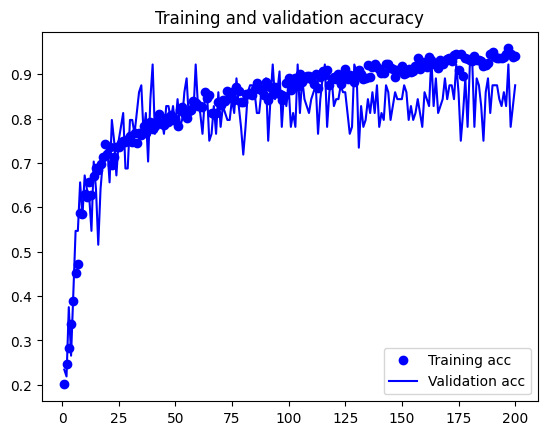

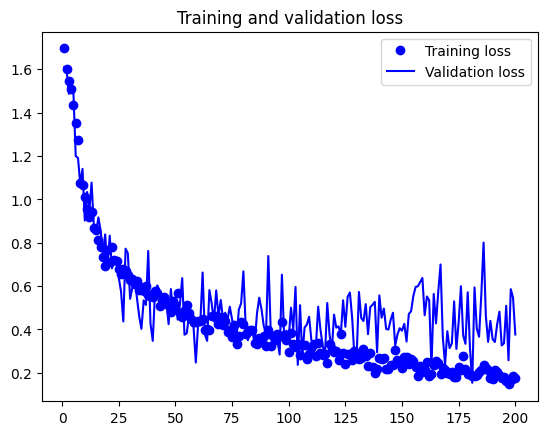

In [117]:
acc= history_da.history['accuracy']
val_acc= history_da.history['val_accuracy']
loss= history_da.history['loss']
val_loss= history_da.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The model show improvements compared to the prvious model. Following I will print the confusion matrix.

In [130]:
val_aug_generator= val_aug_img_data_gen.flow_from_directory(
    dir_base_val,
    target_size=(150,150),
    batch_size=64,
    class_mode='categorical',
    shuffle= False  
)

Found 1497 images belonging to 5 classes.


In [136]:
import numpy
# create confusion matrix
predictions= model_da.predict(val_aug_generator, steps= val_aug_generator.samples / val_aug_generator.batch_size)
predicted_classes= numpy.argmax(predictions, axis=1)

23/23 [==============================] - 2s 102ms/step


In [137]:
animal_true_labels= val_aug_generator.classes
class_labels= list(val_aug_generator.class_indices.keys())

In [140]:
from sklearn.metrics import confusion_matrix
conf_matrix= confusion_matrix(animal_true_labels, predicted_classes)

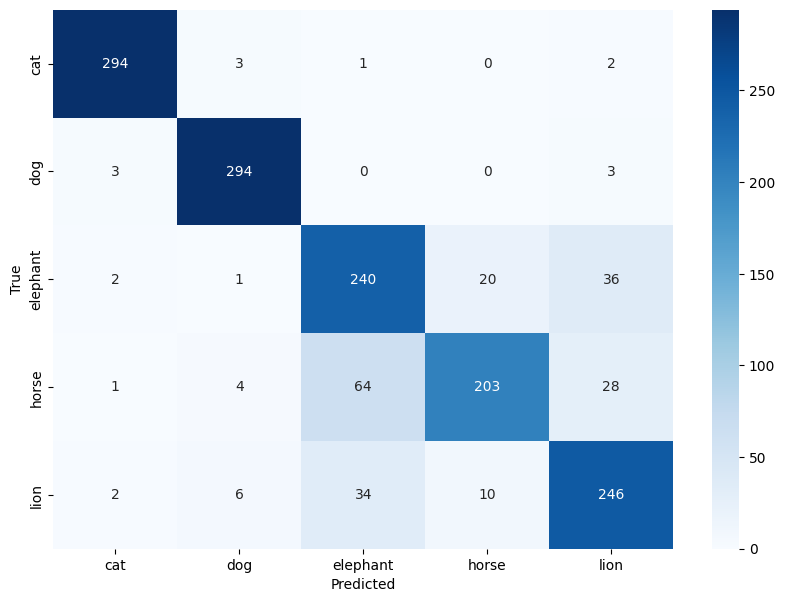

In [141]:
# If you need a textual display of the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [144]:
from sklearn.metrics import classification_report

report = classification_report(animal_true_labels, predicted_classes, target_names=class_labels)

print(report)

              precision    recall  f1-score   support

         cat       0.97      0.98      0.98       300
         dog       0.95      0.98      0.97       300
    elephant       0.71      0.80      0.75       299
       horse       0.87      0.68      0.76       300
        lion       0.78      0.83      0.80       298

    accuracy                           0.85      1497
   macro avg       0.86      0.85      0.85      1497
weighted avg       0.86      0.85      0.85      1497


In [131]:
# save the model
model_da.save('animals.keras')

# Using a pretrained convolutional Model


In [129]:
from keras.applications import VGG16

In [130]:
conv_base= VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(150, 150, 3)
)

In [110]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [132]:
model_cbase_aug= models.Sequential()
model_cbase_aug.add(conv_base)
model_cbase_aug.add(layers.Flatten())
model_cbase_aug.add(layers.Dense(256, activation='relu'))
model_cbase_aug.add(layers.Dense(5, activation='softmax'))



In [133]:
model_cbase_aug.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten_14 (Flatten)        (None, 8192)              0         
                                                                 
 dense_37 (Dense)            (None, 256)               2097408   
                                                                 
 dense_38 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 16813381 (64.14 MB)
Trainable params: 16813381 (64.14 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [135]:
print(f'Number of trainable wieghts: {len(model_cbase_aug.trainable_weights)}')

Number of trainable wieghts: 30


In [136]:
conv_base.trainable = False

In [137]:
print(f'Number of trainable weights after freezing model base: {len(model_cbase_aug.trainable_weights)}')

Number of trainable weights after freezing model base: 4


In [ ]:
steps_per_epoch= len(train_aug_generator) // 32
validation_steps= len(val_aug_generator) // 32

In [138]:
model_cbase_aug.compile(
    optimizer='adam',
    loss= 'categorical_crossentropy',
    metrics=['accuracy']
)

In [139]:
history_model_cbase_aug = model_cbase_aug.fit(
    train_aug_generator,
    steps_per_epoch= steps_per_epoch,
    epochs= 100,
    validation_data= val_aug_generator,
    validation_steps= validation_steps
)

Epoch 1/100
13/13 [==============================] - 10s 745ms/step - loss: 1.9850 - accuracy: 0.3582 - val_loss: 1.4135 - val_accuracy: 0.3750
Epoch 2/100
13/13 [==============================] - 10s 731ms/step - loss: 0.8273 - accuracy: 0.6683 - val_loss: 0.5509 - val_accuracy: 0.8125
Epoch 3/100
13/13 [==============================] - 10s 740ms/step - loss: 0.7477 - accuracy: 0.7091 - val_loss: 0.3827 - val_accuracy: 0.7812
Epoch 4/100
13/13 [==============================] - 10s 729ms/step - loss: 0.6243 - accuracy: 0.7500 - val_loss: 0.6020 - val_accuracy: 0.7188
Epoch 5/100
13/13 [==============================] - 10s 739ms/step - loss: 0.5842 - accuracy: 0.7764 - val_loss: 0.6971 - val_accuracy: 0.6875
Epoch 6/100
13/13 [==============================] - 10s 731ms/step - loss: 0.6617 - accuracy: 0.7260 - val_loss: 0.6956 - val_accuracy: 0.7188
Epoch 7/100
13/13 [==============================] - 10s 771ms/step - loss: 0.6154 - accuracy: 0.7596 - val_loss: 0.5433 - val_accuracy:

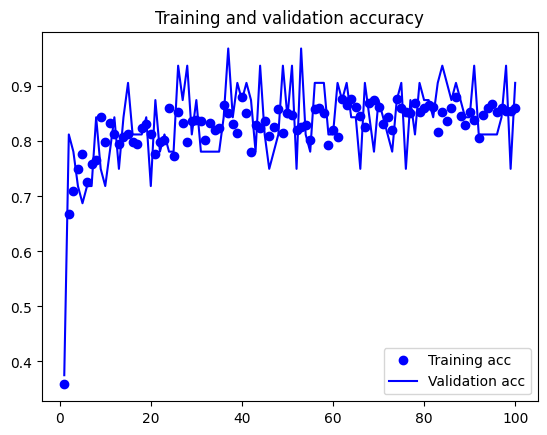

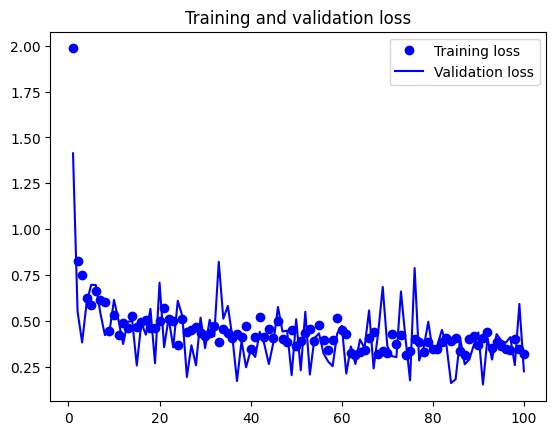

In [140]:
acc= history_model_cbase_aug.history['accuracy']
val_acc= history_model_cbase_aug.history['val_accuracy']
loss= history_model_cbase_aug.history['loss']
val_loss= history_model_cbase_aug.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# References:

[1] Kaggle - Animals: Animals Classification Dataset; Url: https://www.kaggle.com/datasets/antobenedetti/animals/